In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

In [2]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')
y_train = pd.read_csv('data/y_train.csv')
y_test = pd.read_csv('data/y_test.csv')

In [3]:
X2_train = pd.read_csv('data/X2_train.csv')
X2_test = pd.read_csv('data/X2_test.csv')
y2_train = pd.read_csv('data/y2_train.csv')
y2_test = pd.read_csv('data/y2_test.csv')

In [15]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(4105, 18) (4105, 1) (410, 18) (410, 1) (4104, 18) (4104, 1) (410, 18) (410, 1)


In [20]:
models = []
models.append(('LR', LinearRegression()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('RFR', RandomForestRegressor()))
###reshape data for RandomForestRegressor
###boosted ntrees (xg_boost)
###support vector machines

In [57]:
results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=10)
    
    if name != 'RFR':
        model.fit(X_train, y_train)
        cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_mean_squared_error')
    else:
        model.fit(X_train, y_train.values.ravel())
        cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=tscv, scoring='neg_mean_squared_error')
    ###scoring : neg_mean_squared_error, neg_mean_absolute_error, r2
    names.append(name)
    results.append(cv_results)
    
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: -0.797767 (0.628795)
KNN: -1.669319 (1.253311)
RFR: -1.182625 (0.891494)


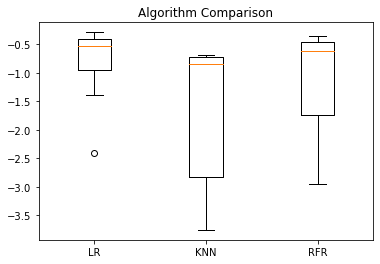

In [37]:
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [38]:
models

[('LR', LinearRegression()),
 ('KNN', KNeighborsRegressor()),
 ('RFR', RandomForestRegressor())]

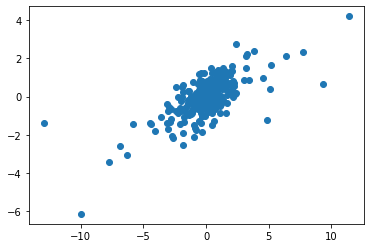

In [39]:
y_pred_LR = models[0][1].predict(X_test)
plt.scatter(y_test, y_pred_LR)

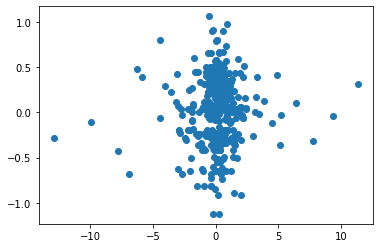

In [40]:
y_predK = models[1][1].predict(X_test)
plt.scatter(y_test, y_predK)
####Hyper parameters

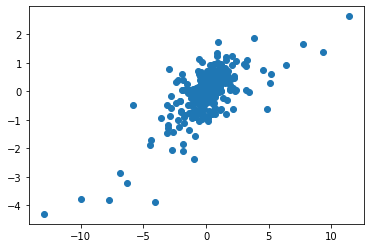

In [41]:
y_predRF = models[2][1].predict(X_test)
plt.scatter(y_test, y_predRF)

In [42]:
###find best base model
###improve other mldels with hyperparameter
#### find best model

In [43]:
###two results based on shifted time

Best Base Model so far seems to be random forrest regressor

In [56]:
for name, model in models:
    print(name, model.get_params())

LR {'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False, 'positive': False}
KNN {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
RFR {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [ ]:
model = KNeighborsRegressor()
param_search = {'n_neighbors' : [1, 5, ]

In [63]:
model = RandomForestRegressor()
param_search = {'n_estimators' : [20, 50, 100]}
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = 'neg_mean_squared_error')
gsearch.fit(X_train, y_train.values.ravel())          
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
print(best_score, best_model)

-1.2212287078232538 RandomForestRegressor(n_estimators=50)
